In a recent project at work, I’ve been working with triangles in 2D and 3D meshes.

The question I got stuck on (even though I’ve [discussed very similar ways of mapping trianges before](http://flothesof.github.io/mapping-triangles.html)) is the following: 

> what is an efficient way to define a map function that goes from a 2D triangle (with local $\xi, \eta$ coordinates) to a given 3D triangle (with $x, y, z$ coordinates)?

Intuitively, it should be relatively easy, since both are surfaces of dimension 2. However, in practice, it took me a long time to find "the right solution". Things finally clicked for me when I read this stackexchange post: https://scicomp.stackexchange.com/questions/25327/finding-shape-functions-for-a-triangle-in-3d-coordinate-space

In this blog post, we will discuss the solution proposed above, but in the context of 2D triangles, since this makes for nicer plots.

So the precise question is got to solve was: 

> what is an efficient way to map a given 2D "reference" triangle to another, arbitrary 2D triangle? assuming the reference triangle can be either an L shape or equilateral.

I know this sounds very specific, I guess we will just get there step by step.

# Introducing the "L reference triangle" 

First of all, let’s define and plot a "L reference triangle" that has points $(0, 0), (1, 0), (0, 1)$.

Text(0, 0.5, '$\\eta$')

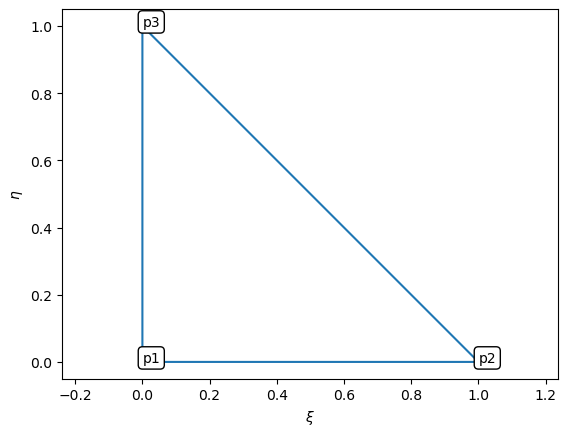

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_triangle(ax, triangle_points):
    pts = np.append(triangle_points, triangle_points[0].reshape(1, -1), axis=0)
    ax.plot(pts[:, 0], pts[:, 1])
    for i, pt in enumerate(triangle_points):
        ax.text(pt[0], pt[1], f"p{i + 1}", bbox=dict(fc="white", boxstyle='round'))

l_ref_triangle = np.array([[0, 0.],
                           [1, 0.],
                           [0, 1.]])

fig, ax = plt.subplots()
plot_triangle(ax, l_ref_triangle)
ax.axis('equal')
ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$\eta$")

# Shape functions on the L reference triangle

Now that we have this geometry, I’ll define so-called shape functions for this triangle (they go by many other names too, e.g. Lagrange interpolation polynomials). 

The shape functions map from the local $\xi, \eta$ coordinates to real values, i.e $f(\xi, \eta) = x \in \mathbb{R}$.

We will introduce 3 shape functions and call them $\Phi_i, i \in [1, 2, 3]$. For our specific triangle, they are

$$
\begin{aligned}
\Phi_1 = 1 - \xi - \eta \\
\Phi_2 = \xi \\
\Phi_3 = \eta
\end{aligned}
$$

Why are these functions called shape functions? Let’s see graphically.

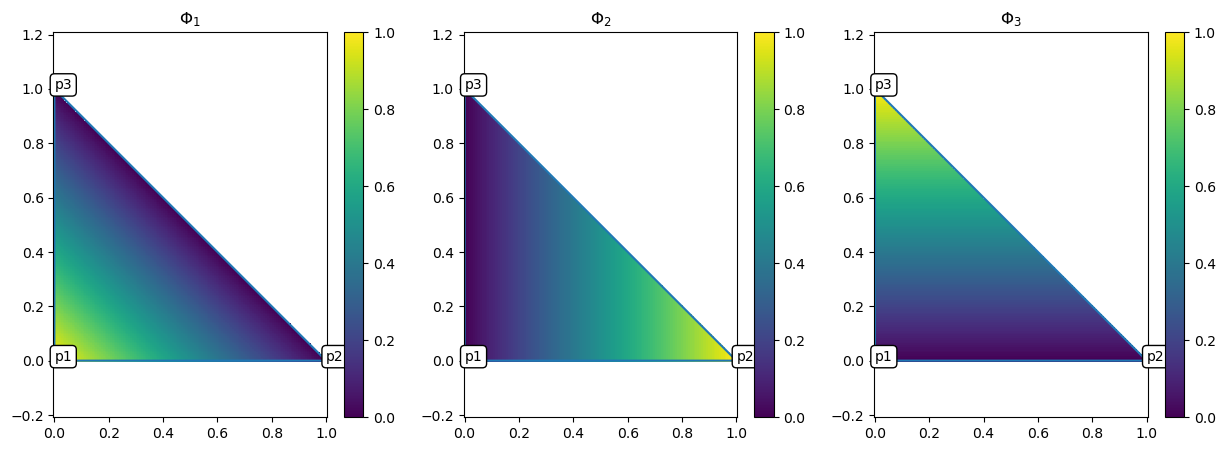

In [2]:
phi1 = lambda x, y: 1 - x - y
phi2 = lambda x, y:x
phi3 = lambda x, y:y

X, Y = np.meshgrid(np.linspace(0, 1, num=150),
                   np.linspace(0, 1, num=151))

eval_shape_func = lambda phi: phi(X.ravel(), Y.ravel()).reshape(X.shape)


fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for ind, (ax, phi) in enumerate(zip(axes, [phi1, phi2, phi3])):
    m = ax.pcolormesh(X, Y, np.where((X <= 1 - Y), eval_shape_func(phi), np.nan))
    plt.colorbar(m, ax=ax)
    ax.axis('equal')
    plot_triangle(ax, l_ref_triangle)
    ax.set_title(f'$\Phi_{ind+1}$')

As you can see in the above plots, each shape function has the very nice property that it is **exactly 1** at one corner of the reference triangle and zero at **both** other vertices. 

# The mapping formula

Why is this 1 and 0 thinginess such a nice property?

Because it allows us to define a transformation from the local coordinates $(\xi, \eta)$ to coordinates inside another triangle!

We denote the points of the triangle to which we want to map by $X_i, i=1..3$. Then, a mapping from local coordinates in the L reference triangle to the one defined by the $X_i$s can be written:

$$
(x, y) = \sum_{i=1}^3 \Phi_i(\eta, \xi) X_i
$$

(side note: this exact formula also works for points in a 3D triangle!)

# Testing the mapping

Let’s try this out and map to a target triangle that I will call `small_triangle`. 

We can convert the above formula to a `map_to` function that takes input $(\xi, \eta)$ coordinates and outputs points in the target triangle frame.

In [3]:
small_triangle = np.array([[0.5, 0.5],
                           [1., 0.5],
                           [0.5, 1.]])

def map_to(xi, eta, new_triangle_points):
    return sum(phi(xi, eta) * p for phi, p in zip([phi1, phi2, phi3], new_triangle_points))

# unit test: should be equal to first vertex of the small triangle
np.allclose(map_to(0, 0, small_triangle), small_triangle[0])

True

It will be useful to apply that function to severeal points so we can write a `map_to_vectorized` function that allows us to evaluate several points at once.

In [4]:
def map_to_vectorized(xi, eta, new_triangle_points):
    return sum(phi(xi, eta) * p.reshape(-1, 1) for phi, p in zip([phi1, phi2, phi3], new_triangle_points))

map_to_vectorized(X.ravel(), Y.ravel(), small_triangle)

array([[0.5       , 0.5033557 , 0.50671141, ..., 0.99328859, 0.9966443 ,
        1.        ],
       [0.5       , 0.5       , 0.5       , ..., 1.        , 1.        ,
        1.        ]])

Let’s see where the grid used in the shape function plot lands when passing through our transformation function:

(-0.05, 1.05, -0.05, 1.05)

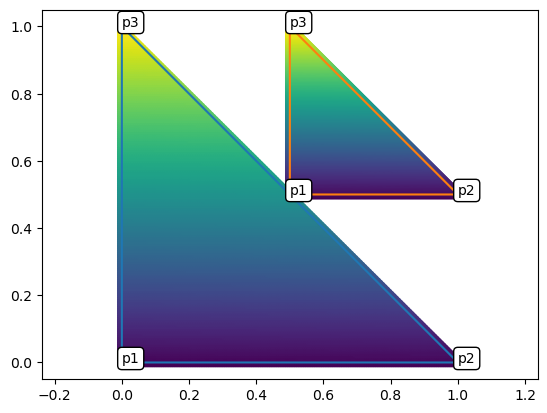

In [5]:
X_filt = np.where((X <= 1 - Y), X, np.nan).ravel()
Y_filt = np.where((X <= 1 - Y), Y, np.nan).ravel(), 

fig, ax = plt.subplots()
plot_triangle(ax, l_ref_triangle)
plot_triangle(ax, small_triangle)
ax.scatter(X_filt, Y_filt, c=np.arange(X_filt.size))
ax.scatter(*map_to_vectorized(X_filt, 
                              Y_filt, 
                              small_triangle), c=np.arange(X_filt.size))
ax.axis('equal')

Nice! Here we see that we have managed to map the L reference triangle to the small target triangle. The coloring shows which points are related.

What happens if we permute the points of the small triangle, i.e. mapping point 1 to 2 in the small triangle and so on?

(-0.05, 1.05, -0.05, 1.05)

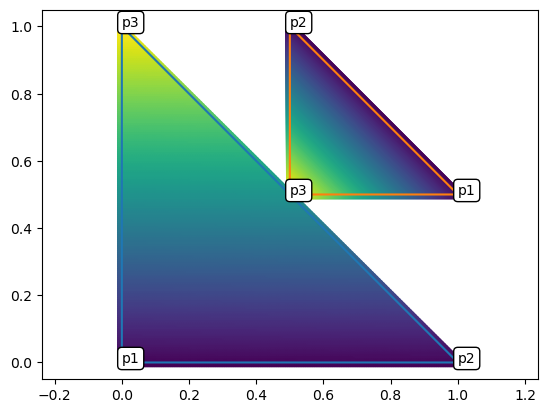

In [6]:
small_triangle2 =  np.array([[1., 0.5],
                             [0.5, 1.],
                             [0.5, 0.5]])


fig, ax = plt.subplots()
plot_triangle(ax, l_ref_triangle)
plot_triangle(ax, small_triangle2)
ax.scatter(X_filt, Y_filt, c=np.arange(X_filt.size))
ax.scatter(*map_to_vectorized(X_filt, 
                              Y_filt, 
                              small_triangle2), c=np.arange(X_filt.size))
ax.axis('equal')

We see that the corners have been exchanged by the mapping, since the corresponding vertices have been exchanged.

# An equilateral reference triangle

As I briefly mentioned in the introduction, what happens if we have a different reference triangle? This has actually happenned to me in the context of numerical quadrature (as we will see at the end of the post). 

Our previous approach would not work anymore since, if I change triangles, the shape functions will not be equal to 1 at the right locations. 

How can we adapt to this new reference triangle?

(-1.1, 1.1, -0.6639528095680698, 1.2413030787576955)

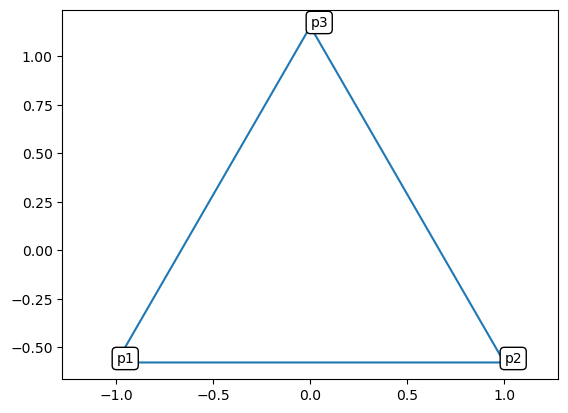

In [7]:
equilat_triangle = np.array([[-1, -1/np.sqrt(3)],
                             [ 1, -1/np.sqrt(3)],
                             [ 0,  2/np.sqrt(3)]])

fig, ax = plt.subplots()
plot_triangle(ax, equilat_triangle)
ax.axis('equal')

The solution is: with the shape functions adapted to the geometry of the equilateral triangle, we could apply the same mapping formula.

So we need shape new functions for this triangle! 

We will derive them using `sympy`.

However, since we already know the shape functions for the L reference triangle, let’s first apply our method to those using `sympy`, before turning to the equilateral triangle.

# Computing the L reference triangle shape functions using sympy

We will first do some imports and create symbolic variables.

In [8]:
import sympy as sp
sp.init_printing()

a, b, c = sp.symbols('a b c')
x, y = sp.symbols('x y')

shape_func = lambda x, y: a + b*x + c*y

To find the shape functions, we write the symbolic equations $\Phi_i(p_i) = \delta_{ij}$, where $\delta_{ij}$ is Kronecker’s discrete delta function. 

We then ask `sympy` to solve the system of equations:

In [9]:
kron_delta = lambda i, j: int(i == j)

def solve_shape_functions(triangle):
    """Returns shape functions for input triangle."""
    shape_funcs = []
    for vertex in range(3):
        equations = []
        for i in range(3):
            eq = shape_func(*triangle[i]) - kron_delta(i, vertex)
            equations.append(eq)
        sol = sp.solve(equations)
        shape_funcs.append(shape_func(x, y).subs(sol))
    return shape_funcs


solve_shape_functions(l_ref_triangle)

This is what we expect! So let’s move on and  apply the same function to the equilateral triangle.

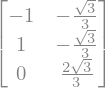

In [10]:
equilat_triangle_sympy = sp.Array([[-1, -1/sp.sqrt(3)],
                             [ 1, -1/sp.sqrt(3)],
                             [ 0,  2/sp.sqrt(3)]])

equilat_triangle_sympy

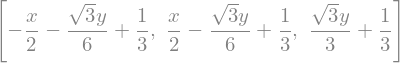

In [11]:
solve_shape_functions(equilat_triangle_sympy)

Great, we have new shape functions for our equilateral triangle. Do they work as expected?

# Testing the new shape functions

We can test the new shape functions by mapping the reference equilateral triangle to the already defined L reference triangle and the small triangle.

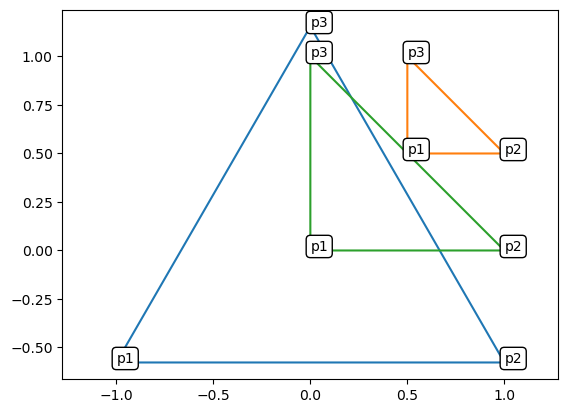

In [12]:
phi1_eqt = lambda x, y: 1/3. - x/2. - np.sqrt(3)/6. * y
phi2_eqt = lambda x, y: 1/3. + x/2. - np.sqrt(3)/6. * y
phi3_eqt = lambda x, y: 1/3. + np.sqrt(3)/3. * y

def map_to_vectorized_eqt(xi, eta, new_triangle_points):
    return sum(phi(xi, eta) * p.reshape(-1, 1) for phi, p in zip([phi1_eqt, phi2_eqt, phi3_eqt], new_triangle_points))

mapped = map_to_vectorized_eqt(equilat_triangle[:, 0], equilat_triangle[:, 1], small_triangle)
mapped2 = map_to_vectorized_eqt(equilat_triangle[:, 0], equilat_triangle[:, 1], l_ref_triangle)

fig, ax = plt.subplots()
plot_triangle(ax, equilat_triangle)
plot_triangle(ax, mapped.T)
plot_triangle(ax, mapped2.T)
ax.axis('equal')

This seems to work!

We can also plot the shape function values to check they are doing as expected.

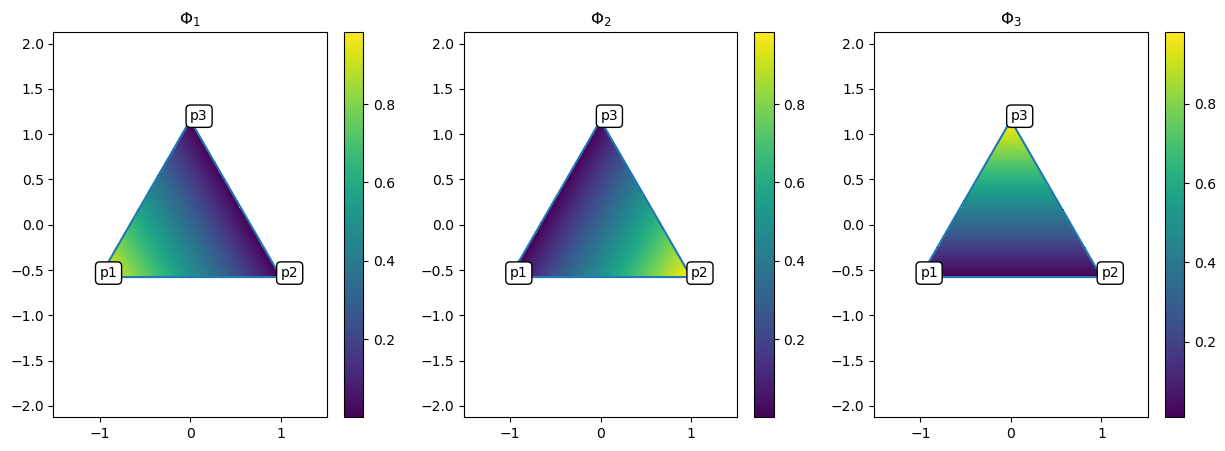

In [13]:
X2, Y2 = np.meshgrid(np.linspace(-1.5, 1.5, num=150),
                   np.linspace(-1.5, 1.5, num=151))

eval_shape_func_eqt = lambda phi: phi(X2.ravel(), Y2.ravel()).reshape(X2.shape)
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))



for ind, (ax, phi) in enumerate(zip(axes, [phi1_eqt, phi2_eqt, phi3_eqt])):
    m = ax.pcolormesh(X2, Y2, np.where(((X2) >= 1/np.sqrt(3) * (Y2 - 2/np.sqrt(3))) & \
                                       (Y2 > -1/np.sqrt(3)) & \
                                       ((X2) <= -1/np.sqrt(3) * (Y2 - 2/np.sqrt(3))),
                                       eval_shape_func_eqt(phi), np.nan))
    plt.colorbar(m, ax=ax)
    ax.axis('equal')
    plot_triangle(ax, equilat_triangle)
    ax.set_title(f'$\Phi_{ind+1}$')

Looks good! I can finally use this to do high order quadratures on the triangle!

# High order quadrature on the triangle

Using quadrature formulas, integrals can be computed by sums on triangles. This means we can replace a continuous integral like $\iint f(x, y) dxdy$ by a sum like $\sum_{i, j} w_{ij} f(x_{i,j}, y_{i, j})$, where $w_{ij}$ are some kind of weights.

One such example formula is the Xiao-Gimbutas order 10 quadrature (as taken from [modepy](https://github.com/inducer/modepy)):

In [14]:
quad_data = {
        "points": np.array([
            [-5.3776427755281e-17, -0.560630643491333],
            [0.485520379403511, 0.280315321745667],
            [-0.485520379403511, 0.280315321745667],
            [-0.942581754271476, -0.544199829561867],
            [0.942581754271476, -0.544199829561866],
            [0.0, 1.08839965912373],
            [-0.697806869315934, -0.517207194291495],
            [0.796818003934476, -0.345714878617139],
            [-0.0990111346185413, 0.862922072908635],
            [0.697806869315934, -0.517207194291495],
            [0.0990111346185421, 0.862922072908635],
            [-0.796818003934476, -0.345714878617139],
            [-5.55111512312578e-17, 2.22044604925031e-16],
            [-0.309031000096134, -0.512255075947674],
            [0.59814140903628, -0.0115011586663268],
            [-0.289110408940145, 0.523756234614001],
            [0.309031000096134, -0.512255075947674],
            [0.289110408940145, 0.523756234614001],
            [-0.59814140903628, -0.0115011586663264],
            [-0.44654496194426, -0.25781285398379],
            [0.44654496194426, -0.25781285398379],
            [0.0, 0.51562570796758],
            [2.77555756156289e-17, -0.328748396510112],
            [0.284704462831157, 0.164374198255056],
            [-0.284704462831157, 0.164374198255056],
        ]),
        "weights": np.array([
            0.0169612642809767,
            0.0169612642809767,
            0.0169612642809767,
            0.0110597666111444,
            0.0110597666111444,
            0.0110597666111444,
            0.0501641429974703,
            0.0501641429974703,
            0.0501641429974703,
            0.0501641429974703,
            0.0501641429974703,
            0.0501641429974703,
            0.144825210684212,
            0.0670980012538894,
            0.0670980012538894,
            0.0670980012538894,
            0.0670980012538894,
            0.0670980012538894,
            0.0670980012538894,
            0.136197684391398,
            0.136197684391398,
            0.136197684391398,
            0.130332195175317,
            0.130332195175317,
            0.130332195175317,
        ]),
    }

The actual use of the mapping formula describe above that solves my problem is then: how do I map the quadrature points from the reference triangle to the arbitrary triangle?

We will do this and plot little circles to show the weight magnitude.

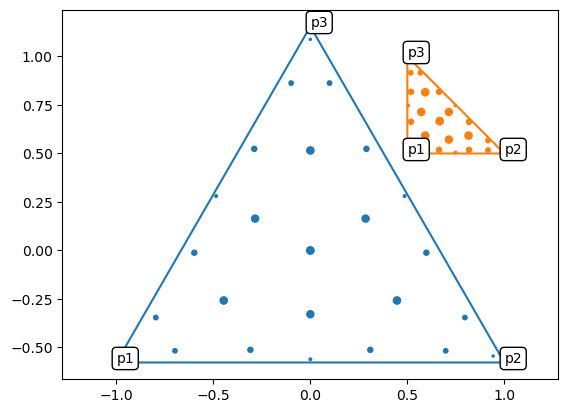

In [15]:
mapped = map_to_vectorized_eqt(quad_data['points'][:, 0], quad_data['points'][:, 1], small_triangle)

fig, ax = plt.subplots()
ax.scatter(quad_data['points'][:, 0], quad_data['points'][:, 1], quad_data['weights']*200)
plot_triangle(ax, equilat_triangle)

plot_triangle(ax, map_to_vectorized_eqt(equilat_triangle[:, 0], equilat_triangle[:, 1], small_triangle).T)
ax.scatter(mapped.T[:, 0], mapped.T[:, 1], quad_data['weights']*200)

ax.axis('equal')

This visualization shows exactly where the quadrature nodes get mapped in the target triangle. From there, we can apply the summation formula and compute approximate integrals, yay!

*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20240319_triangleMapping2D3D.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20240319_triangleMapping2D3D.ipynb).*